In [8]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io
import os
import glob
from PIL import Image
from tqdm import tqdm  # Import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
torch.__version__

'2.4.0'

In [10]:
import tensorflow as tf

In [11]:
tf.__version__

'2.16.1'

In [12]:
tf.keras.__version__

'3.3.3'

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_path = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import shutil

def filter_and_reduce_dataset(train_path, exclude_classes, target_folder, reduction_factor=0.5):
    """
    Filter and reduce the dataset by excluding certain classes and selecting a subset of images.
    
    Parameters:
    - train_path: Path to the original dataset
    - exclude_classes: List of folder names to exclude
    - target_folder: Path to the folder where the filtered dataset will be stored
    - reduction_factor: Proportion of images to keep from each folder (0.5 means keep 50%)
    """
    # Create the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    # Loop through the folders in the dataset
    for class_name in os.listdir(train_path):
        class_path = os.path.join(train_path, class_name)
        
        # Skip the folders that should be excluded
        if class_name in exclude_classes:
            continue
        
        # Create a folder in the target directory
        target_class_folder = os.path.join(target_folder, class_name)
        if not os.path.exists(target_class_folder):
            os.makedirs(target_class_folder)
        
        # Get all image file names in the current class folder
        image_files = os.listdir(class_path)
        
        # Calculate the number of images to keep based on the reduction factor
        num_images_to_keep = int(len(image_files) * reduction_factor)
        
        # Randomly select images to keep
        selected_images = random.sample(image_files, num_images_to_keep)
        
        # Copy selected images to the target folder
        for image in selected_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(target_class_folder, image))

# Specify the classes to exclude
exclude_classes = ["del", "nothing", "space"]

# Path to store the reduced dataset
reduced_dataset_path = "/kaggle/working/reduced_asl_dataset"

# Reduce the dataset by 50% (you can adjust the reduction factor)
filter_and_reduce_dataset(train_path, exclude_classes, reduced_dataset_path, reduction_factor=0.5)

# Now use ImageDataGenerator on the reduced dataset
image_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

# Creating the training and validation generators from the reduced dataset
train_generator = datagen.flow_from_directory(
    reduced_dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    reduced_dataset_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 31200 images belonging to 26 classes.
Found 7800 images belonging to 26 classes.


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, concatenate, Input
from tensorflow.keras.models import Model

# Define the Inception block
def inception_block_v5(x, filters):
   
    branch1x1 = Conv2D(filters[0], (1, 1), padding='same')(x)
    branch1x1 = BatchNormalization()(branch1x1)
    branch1x1 = Activation('relu')(branch1x1)


    branch3x3 = Conv2D(filters[1], (1, 1), padding='same')(x)
    branch3x3 = BatchNormalization()(branch3x3)
    branch3x3 = Activation('relu')(branch3x3)
    branch3x3 = Conv2D(filters[2], (3, 3), padding='same')(branch3x3)
    branch3x3 = BatchNormalization()(branch3x3)
    branch3x3 = Activation('relu')(branch3x3)


    branch5x5 = Conv2D(filters[3], (1, 1), padding='same')(x)
    branch5x5 = BatchNormalization()(branch5x5)
    branch5x5 = Activation('relu')(branch5x5)
    branch5x5 = Conv2D(filters[4], (5, 5), padding='same')(branch5x5)
    branch5x5 = BatchNormalization()(branch5x5)
    branch5x5 = Activation('relu')(branch5x5)


    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), padding='same')(branch_pool)
    branch_pool = BatchNormalization()(branch_pool)
    branch_pool = Activation('relu')(branch_pool)

    x = concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return x


# Define the full InceptionV5 architecture
def InceptionV5(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Convolution and MaxPooling
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32, (3, 3), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    # Inception Blocks 
    x = inception_block_v5(x, [64, 48, 64, 8, 16, 32])
    x = inception_block_v5(x, [128, 64, 96, 16, 32, 64])
    x = inception_block_v5(x, [192, 96, 128, 32, 64, 128])
    x = inception_block_v5(x, [256, 128, 192, 48, 96, 160])

    # AveragePooling and Dropout
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Fully Connected Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs, name="InceptionV5")
    return model


# Define hyperparameters
input_shape = (224, 224, 3)  # Image size
num_classes = 26             # Change based on your dataset

# Instantiate the model
model = InceptionV5(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "InceptionV5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 111, 111,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 109, 109,  │      9,248 │ activation_27[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        128 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 109, 109,  │     18,496 │ activation_28[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        256 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ activation_29[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 54, 54,    │      3,120 │ max_pooling2d_5[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 54, 54, 8) │        520 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        192 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54, 8) │         32 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 54, 54, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 1,159,426 (4.42 MB)

 Trainable params: 1,154,866 (4.41 MB)

 Non-trainable params: 4,560 (17.81 KB)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint


epochs = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
  # Add the callback to the training process
)


Epoch 1/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 145s 148ms/step - accuracy: 0.9811 - loss: 0.0777 - val_accuracy: 0.8503 - val_loss: 0.4930
Epoch 2/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 144s 148ms/step - accuracy: 0.9857 - loss: 0.0558 - val_accuracy: 0.7972 - val_loss: 0.6307
Epoch 3/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 144s 148ms/step - accuracy: 0.9916 - loss: 0.0352 - val_accuracy: 0.8681 - val_loss: 0.4345
Epoch 4/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 144s 148ms/step - accuracy: 0.9940 - loss: 0.0258 - val_accuracy: 0.7076 - val_loss: 0.8498
Epoch 5/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 145s 148ms/step - accuracy: 0.9924 - loss: 0.0303 - val_accuracy: 0.8912 - val_loss: 0.3520
Epoch 6/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 146s 149ms/step - accuracy: 0.9954 - loss: 0.0163 - val_accuracy: 0.9155 - val_loss: 0.2714
Epoch 7/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 145s 149ms/step - accuracy: 0.9897 - loss: 0.0343 - val_accuracy: 0.9305 - val_loss: 0.2094
Epoch 8/10
975/975 ━━━━━━━━━━━━━━━━━━━━ 145s 148ms/step - accuracy: 0.9966 -

In [20]:
model.save('/kaggle/working/final_model.keras') 

In [15]:
# Save the weights
model.save_weights("/kaggle/working/saved_model.weights.h5")
print("Model architecture and weights saved separately.")


Model architecture and weights saved separately.


In [27]:
import shutil

# Create a zip file named 'file.zip' from the '/kaggle/working/' directory
shutil.make_archive('file', 'zip', '/kaggle/working/')

# Provide a download link
from IPython.display import FileLink
display(FileLink('file.zip'))




/kaggle/working/file.zip

In [22]:
from sklearn.metrics import classification_report


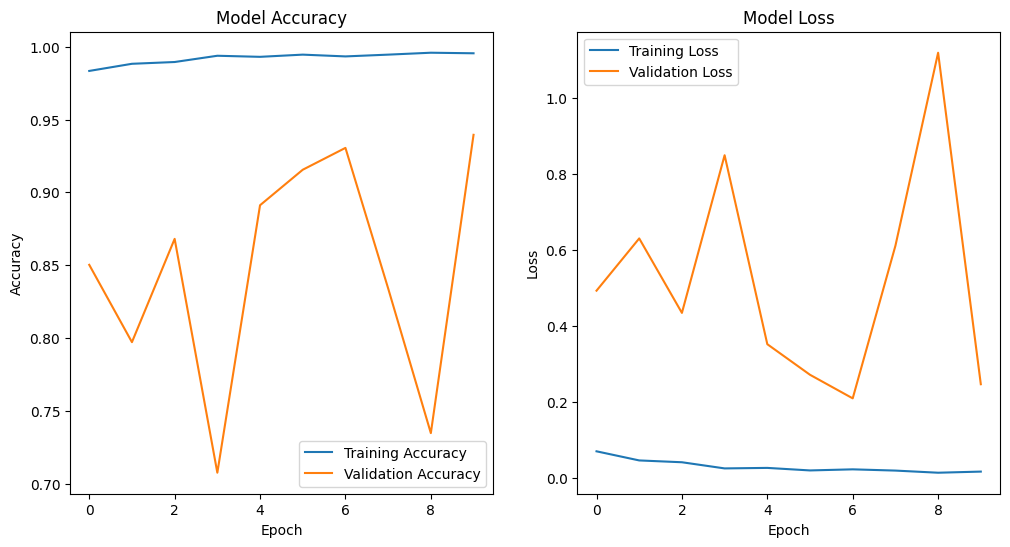

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

In [23]:


# Step 8: Plot the training and validation loss and accuracy
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

# Call the plotting function to visualize training and validation metrics
plot_training_history(history)

# Generate a classification report (Assuming you have validation generator or a dataset to validate on)
def evaluate_classification_report(model, generator, steps):
    # Get true labels and predictions
    true_labels = []
    predictions = []
    class_indices = generator.class_indices
    class_labels = list(class_indices.keys())

    # Loop through the generator to get all predictions and true labels
    for i in range(steps):
        images, labels = next(generator)
        pred = model.predict(images)
        true_labels.extend(tf.argmax(labels, axis=1).numpy())
        predictions.extend(tf.argmax(pred, axis=1).numpy())

    # Print classification report
    print(classification_report(true_labels, predictions, target_names=class_labels))

# Calculate and display the classification report
steps = val_generator.samples // batch_size
evaluate_classification_report(model, val_generator, steps)

In [ ]:
def evaluate_classification_report(model, generator, steps):
    # Get true labels and predictions
    true_labels = []
    predictions = []
    class_indices = generator.class_indices
    class_labels = list(class_indices.keys())

    # Loop through the generator to get all predictions and true labels
    for i in range(steps):
        images, labels = next(generator)
        pred = model.predict(images)
        true_labels.extend(tf.argmax(labels, axis=1).numpy())
        predictions.extend(tf.argmax(pred, axis=1).numpy())

    # Print classification report
    print(classification_report(true_labels, predictions, target_names=class_labels))

# Calculate and display the classification report
steps = val_generator.samples // batch_size
evaluate_classification_report(model, val_generator, steps)

In [5]:
from tensorflow.keras.models import load_model

# Load the trained InceptionV5 model

model=load_model("/kaggle/input/model-sign-text/final_model.keras")

In [7]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path, target_size=(224, 224)):
    """
    Load and preprocess the image.
    
    Parameters:
    - img_path: Path to the image file.
    - target_size: The size to which the image should be resized.
    
    Returns:
    - Preprocessed image array.
    """
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image if required by your model
    
    return img_array

def predict_single_image(model, img_path, class_labels, target_size=(224, 224)):
    """
    Predict the class of a single image.
    
    Parameters:
    - model: Trained Keras model.
    - img_path: Path to the image file.
    - class_labels: List of class labels.
    - target_size: The size to which the image should be resized.
    
    Returns:
    - Predicted class label for the image.
    """
    # Preprocess the image
    img_array = preprocess_image(img_path, target_size)

    # Predict the class
    pred = model.predict(img_array)
    predicted_class_index = np.argmax(pred, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]

    # Print and return the predicted class label
    print(f"Predicted Class: {predicted_class_label}")
    return predicted_class_label

# Example usage:
# Define the path to your image
img_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/G_test.jpg'

# Assuming you have the trained model and class_labels already defined
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']  # Replace with your class labels
predicted_label = predict_single_image(model, img_path, class_labels, target_size=(224, 224))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class: G
